In [1]:
import sys
sys.path.append('..')
import torch
import torch.nn as nn
from catalyst import dl
from catalyst import utils
from models.net import Net
from callabacks import DecisionBoundaryCallback, LogPRCurve
from runners import ClassificationRunner
from models.metrics import BalancedAccuracyMetric
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from experiments.experiment_utils import logger
from datasets import CirclesDataSet
from models.transforms import ToTensor
from visualization_utils import visualize_decision_boundary, visualize_dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


In [49]:
torch.random.manual_seed(42)
dataset_train = CirclesDataSet(noise=0.05,majority_samples=1000, minority_samples=100, 
                               noisy_minority_samples =900,
                               noisy_majority_samples=0,
                               transform=ToTensor(), target_transform=ToTensor())
dataset_valid = CirclesDataSet(train=False, noise=0.05, majority_samples=500,
                               minority_samples=30, transform=ToTensor(), target_transform=ToTensor())

model = Net()
checkpoint = utils.load_checkpoint(path="../experiments/logs/circles/imbalance/checkpoints/last.pth")
utils.unpack_checkpoint(checkpoint=checkpoint, model=model)


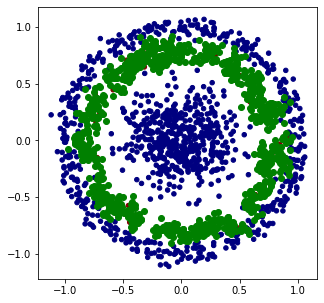

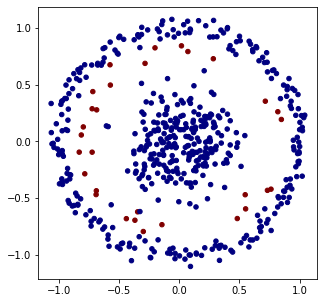

In [50]:
fig_train = visualize_dataset(dataset_train)
plt.scatter(dataset_train.synthetic_data[:,0], dataset_train.synthetic_data[:,1], c='g')
fig_test = visualize_dataset(dataset_valid)

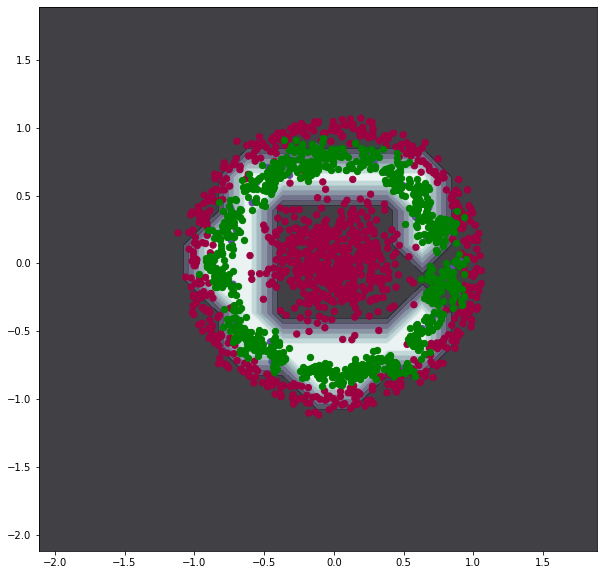

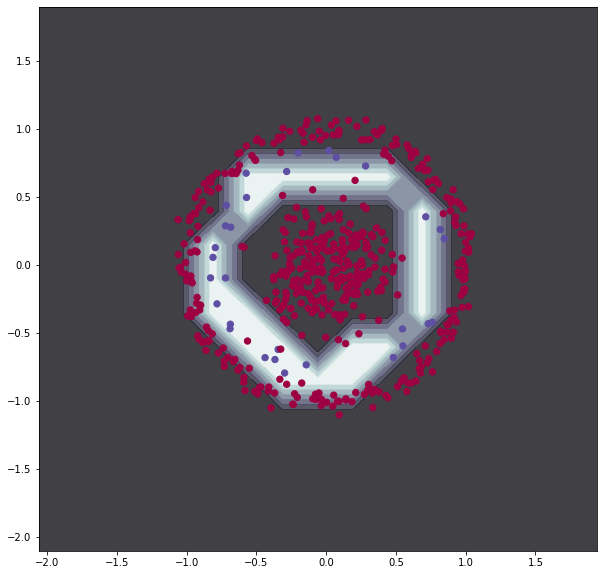

In [51]:
fig = visualize_decision_boundary(dataset_train, model)
fig = visualize_decision_boundary(dataset_valid, model)

In [10]:
import warnings
# warnings.filterwarnings('ignore')
torch.random.manual_seed(42)

dataset_train = CirclesDataSet(noise=0.05, majority_samples=2000, minority_samples=100,
                               noisy_majority_samples=0, noisy_minority_samples=900,
                               transform=ToTensor(), target_transform=ToTensor())

dataset_valid = CirclesDataSet(train=False, noise=0.05, majority_samples=1000,
                               minority_samples=50, transform=ToTensor(), target_transform=ToTensor())

model = Net()

criterion = {
    "bce": nn.BCEWithLogitsLoss(pos_weight=torch.tensor(20.)),
    }
optimizer = {
    'model': torch.optim.SGD(model.classifier.parameters(), lr=0.001),
}

loaders = {
    "train": DataLoader(dataset_train, batch_size=64, shuffle=True),
    "valid": DataLoader(dataset_valid, batch_size=64, shuffle=False),
}

with logger('./logs/debug', mode='debug') as log:

    runner = ClassificationRunner(train_on_synthetic=True)
    checkpoint = utils.load_checkpoint(path="../experiments/logs/circles/bce/checkpoints/last.pth")
    utils.unpack_checkpoint(checkpoint=checkpoint, model=model)

    runner.train(model=model,
                 criterion=criterion,
                 optimizer=optimizer,
                 loaders=loaders,
                 logdir=log,
                 num_epochs=200,
                 hparams={"lr_z": 0.01,
                          "lr_meta": 0.001},
                 callbacks={
                     "visualization": dl.ControlFlowCallback(base_callback = DecisionBoundaryCallback(show=True),
                                                             loaders = 'train')

                 },
                 )
                 

KeyboardInterrupt: 